# Instacart Market Basket Analysis

In [64]:
#https://www.kaggle.com/c/instacart-market-basket-analysis

## Import libraries

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()

%matplotlib inline

In [66]:
ls

aisles.csv                 order_products__train.csv
departments.csv            orders.csv
instacart.ipynb            products.csv
order_products__prior.csv  sample_submission.csv


Lets read our tables into dataframes

In [67]:
aisles_df = pd.read_csv('aisles.csv')
departments_df = pd.read_csv('departments.csv')
order_products_prior_df = pd.read_csv('order_products__prior.csv')
order_products_train_df = pd.read_csv('order_products__train.csv')
orders_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')

In [68]:
orders_df.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [69]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [70]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


As we can see, it looks like orders_df should contain both the orders in the prior and train dfs. Theres this interesting column eval_set in orders_df that might explain the distribution.

In [71]:
def get_unique_count(x):
    return len(np.unique(x))

orders_df.groupby('eval_set')['user_id'].aggregate(get_unique_count)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

Looks like in total we have 206,209 users, 131,209 in the training set, and 75,000 that we need to predict.

In [72]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Lets do some explorator analysis on this dataframe

Up first, lets see the order distribution among days of the week.

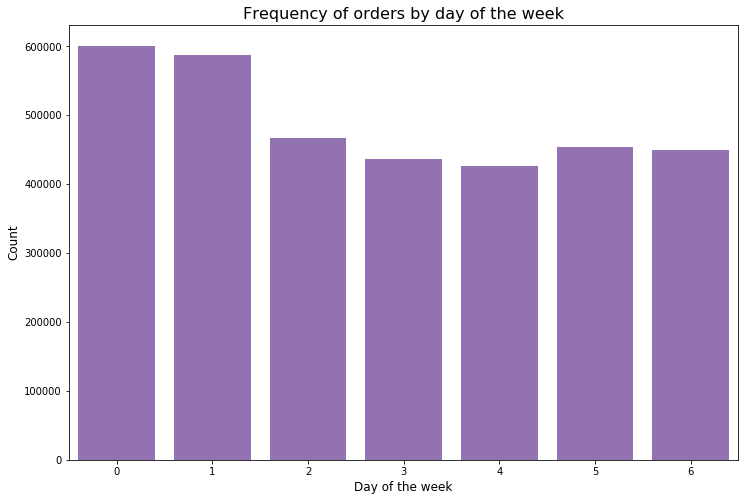

In [73]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders_df, color=color[4])
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Frequency of orders by day of the week', fontsize=16)
plt.show()

Looks like most of the orders are performed on the weekend, Saturday being 0, and Sunday 1.

Next, lets look at the distribution of orders during the different hours of the day.

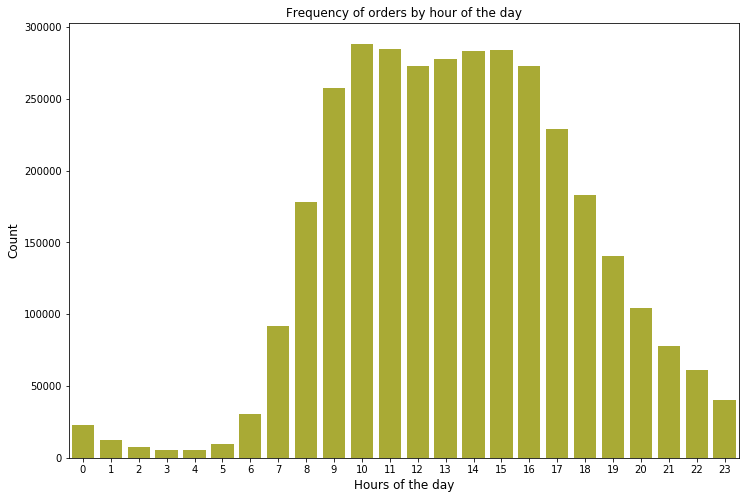

In [74]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day',data=orders_df,color=color[8])
plt.ylabel('Count',fontsize=12)
plt.xlabel('Hours of the day',fontsize=12)
plt.title('Frequency of orders by hour of the day')
plt.show()

Looks like throughout the day, orders seem to be congested between the morning and early evening hours.

Lets see the distribution of the number of days between each order.

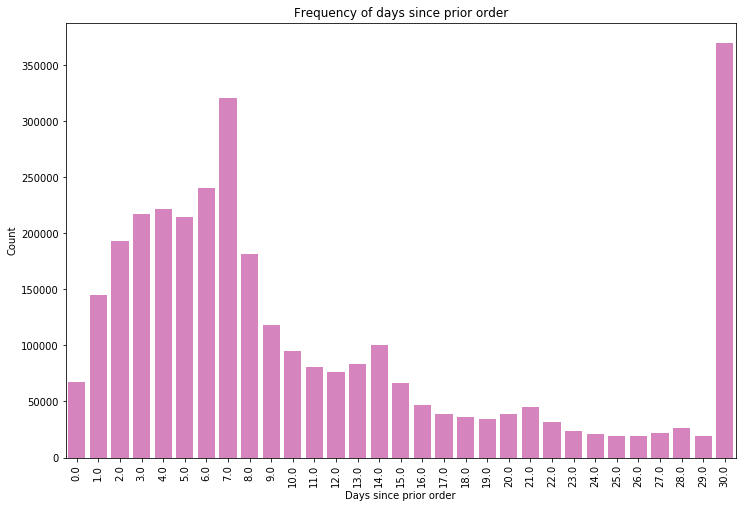

In [75]:
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order',data=orders_df,color=color[6])
plt.ylabel('Count')
plt.xlabel('Days since prior order')
plt.xticks(rotation='vertical')
plt.title('Frequency of days since prior order')
plt.show()

Looks like the two biggest peaks are at 7 days and 30 days (week end and month end). There seem to also be smaller peaks at 14 days and 21 days. Together, that tells me that the orders seem to peak at the end of the weeks. 

The largest culster of orders seems to be within the first week, indicating that people seem to buy the largest amount in that first week, and then perhaps re-up in smaller quantities at the end of weeks.

Before we go further, lets look at the other dataframes.

In [76]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [77]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [78]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
